In [1]:
!pip install -q requests pandas trafilatura cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.9/837.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 10.3 MB/s eta 0:00:00


In [5]:
import os
import requests
import pandas as pd
import time
import trafilatura
import cloudscraper
import re
from datetime import datetime, timedelta
from pathlib import Path
from google.colab import userdata

# -------------------------
# 1. 載入憑證
# -------------------------
try:
    APP_ID = userdata.get('ADZUNA_APP_ID')
    APP_KEY = userdata.get('ADZUNA_APP_KEY')
except:
    APP_ID = None
    APP_KEY = None

if not APP_ID or not APP_KEY:
    raise ValueError("❌ Missing Adzuna API credentials. 請檢查 Colab 左側『鑰匙』圖示內的名稱是否正確。")

# -------------------------
# 2. 配置設定
# -------------------------
COUNTRY = "us"
CITY = "Baltimore"
KEYWORDS = ["data scientist", "data analyst"]
RESULTS_PER_PAGE = 50
MAX_PAGES = 5
DAYS_BACK = 60
BASE_URL = f"https://api.adzuna.com/v1/api/jobs/{COUNTRY}/search"

# 🎯 職稱過濾
TARGET_TITLE_KEYWORDS = ["data scientist", "senior data scientist", "sr. data scientist", "lead data scientist", "principal data scientist", "staff data scientist", "data analyst", "senior data analyst"]
EXCLUDED_TITLE_KEYWORDS = ["architect", "engineer", "manager", "consultant", "director", "vp", "vice president", "head of", "marketing", "sales", "product"]

# 🎯 你的專業技能關鍵字字典 (已整合你提供的清單)
SKILL_KEYWORDS = {
    'Programming': ['Python', 'SQL', ' R ', 'SAS', 'Stata', 'Julia', 'C++', 'Java', 'Scala', 'Go', 'Bash', 'Shell'],
    'Cloud & Big Data': ['AWS', 'Azure', 'GCP', 'Google Cloud', 'Snowflake', 'Databricks', 'Spark', 'Hadoop', 'Kafka', 'Redshift', 'BigQuery', 'Athena', 'Glue', 'Terraform', 'Airflow'],
    'Databases': ['PostgreSQL', 'MySQL', 'MongoDB', 'NoSQL', 'SQL Server', 'Oracle', 'Cassandra'],
    'ML & AI': ['Machine Learning', 'Deep Learning', 'Reinforcement Learning', 'NLP', 'Natural Language Processing', 'Computer Vision', 'Generative AI', 'GenAI', 'LLM', 'GPT', 'Scikit-learn', 'TensorFlow', 'PyTorch', 'Keras', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Stats & Research': ['Statistics', 'Biostatistics', 'Causal Inference', 'Epidemiology', 'Econometrics', 'Bayesian', 'Survival Analysis', 'Longitudinal', 'Time Series', 'A/B Testing', 'Experimental Design', 'Propensity Score', 'Clinical Trials', 'Regression', 'Hypothesis Testing', 'RCT', 'GIS', 'Geographic Information Systems'],
    'Visualization & BI': ['Tableau', 'Power BI', 'Looker', 'Qlik', 'Matplotlib', 'Seaborn', 'Plotly', 'Shiny', 'D3.js'],
    'Engineering & DevOps': ['Git', 'GitHub', 'CI/CD', 'Docker', 'Kubernetes', 'MLOps', 'Agile', 'Scrum', 'DevOps'],
    'Degree': ['PhD', 'Ph.D.', 'Doctorate', 'Master', 'M.S.', 'MSc', 'MPH', 'MBA', 'Bachelor']
}

# -------------------------
# 3. 功能函數
# -------------------------
def is_relevant_title(title: str) -> bool:
    if not title: return False
    title_lower = title.lower()
    has_target = any(k in title_lower for k in TARGET_TITLE_KEYWORDS)
    has_excluded = any(k in title_lower for k in EXCLUDED_TITLE_KEYWORDS)
    return has_target and not has_excluded

def quick_skill_scan(text):
    """
    掃描文字中的技能，並按類別分組。
    使用正則表達式 \b 確保精確匹配（避免把 'R' 誤抓在 'Program' 裡）。
    """
    if not text: return ""

    found_categories = []
    text_to_scan = text # 保持原文大小寫，但在 search 時用 re.I

    for category, keywords in SKILL_KEYWORDS.items():
        matched_in_cat = []
        for k in keywords:
            # 建立正則表達式，處理特殊字符並確保邊界
            # 例如 ' R ' 會匹配獨立的 R，'GIS' 會匹配獨立的 GIS
            pattern = r'\b' + re.escape(k.strip()) + r'\b'
            if re.search(pattern, text_to_scan, re.I):
                matched_in_cat.append(k.strip())

        if matched_in_cat:
            # 去重並合併該類別的技能
            found_categories.append(f"{category}: {', '.join(list(set(matched_in_cat)))}")

    return " | ".join(found_categories)

def fetch_full_description(url):
    scraper = cloudscraper.create_scraper(browser={'browser': 'chrome', 'platform': 'windows', 'desktop': True})
    try:
        for _ in range(2):
            response = scraper.get(url, timeout=20)
            if response.status_code == 200:
                content = trafilatura.extract(response.text, include_tables=True)
                if content and len(content) > 300:
                    return content.strip()
            time.sleep(2)
    except:
        pass
    return None

# -------------------------
# 4. 主執行程序
# -------------------------
all_jobs = []
cutoff_date = datetime.now() - timedelta(days=DAYS_BACK)

for keyword in KEYWORDS:
    for page in range(1, MAX_PAGES + 1):
        params = {
            "app_id": APP_ID,
            "app_key": APP_KEY,
            "what": keyword,
            "where": CITY,
            "results_per_page": RESULTS_PER_PAGE,
            "sort_by": "date",
        }

        print(f"📥 Fetching '{keyword}' | page {page}")
        try:
            response = requests.get(f"{BASE_URL}/{page}", params=params)
            response.raise_for_status()
            data = response.json()
        except Exception as e:
            print(f"❌ API Error: {e}")
            break

        results = data.get("results", [])
        if not results: break

        for job in results:
            created = job.get("created")
            created_dt = datetime.fromisoformat(created.replace("Z", ""))
            if created_dt < cutoff_date: continue

            title = job.get("title")
            if not is_relevant_title(title): continue

            # 抓取描述並進行技能掃描
            redirect_url = job.get("redirect_url")
            print(f"   🔍 Analyzing: {title[:40]}...")

            full_desc = fetch_full_description(redirect_url)
            final_description = full_desc if full_desc else job.get("description", "")

            # 這裡會用到新的 SKILL_KEYWORDS 進行掃描
            detected = quick_skill_scan(final_description)

            all_jobs.append({
                "title": title,
                "company": job.get("company", {}).get("display_name"),
                "location": job.get("location", {}).get("display_name"),
                "created": created,
                "detected_skills": detected, # 這裡是關鍵！
                "full_text_status": "Success" if full_desc else "Snippet",
                "description": final_description,
                "redirect_url": redirect_url,
                "keyword": keyword,
            })
            time.sleep(1.2)

# -------------------------
# 5. 儲存結果
# -------------------------
df = pd.DataFrame(all_jobs)
output_name = "jobs_updated_skills.csv"
df.to_csv(output_name, index=False, encoding='utf-8-sig')

print(f"\n✅ 完成！總共抓取 {len(all_jobs)} 筆資料。")
print(f"💾 檔案已儲存至: {output_name}")

📥 Fetching 'data scientist' | page 1
   🔍 Analyzing: Geospatial Data Scientist Intern - Netwo...
   🔍 Analyzing: Data Scientist - ID/STRAT and Program Ev...
   🔍 Analyzing: Data Scientist - Cost of Care Reporting ...
   🔍 Analyzing: Data Scientist- Value-Based Care Reporti...
   🔍 Analyzing: Data Scientist Fellow, Baseball Analytic...
   🔍 Analyzing: AI & GenAI Data Scientist-Senior Associa...
   🔍 Analyzing: Data Scientist (Oncology) - Staff...
   🔍 Analyzing: Data Scientist...
   🔍 Analyzing: Sr. Data Scientist - Clinical AI...
   🔍 Analyzing: Data Scientist Fellow...
📥 Fetching 'data scientist' | page 2
   🔍 Analyzing: Sr Principal Data Scientist...
   🔍 Analyzing: Senior Data Scientist...
   🔍 Analyzing: Sr Principal Data Scientist with Securit...
   🔍 Analyzing: Sr Principal Data Scientist...
   🔍 Analyzing: Data Scientist, Senior with Security Cle...
   🔍 Analyzing: Data Scientist, Senior with Security Cle...
   🔍 Analyzing: Senior Software Developer/Data Scientist...
📥 Fetching 

📥 Fetching 'data scientist' | page 1
   🔍 Anti-403 Scraping for: Geospatial Data Scientist Intern - ...
   🔍 Anti-403 Scraping for: Data Scientist - ID/STRAT and Progr...
   🔍 Anti-403 Scraping for: Data Scientist - Cost of Care Repor...
   🔍 Anti-403 Scraping for: Data Scientist- Value-Based Care Re...
   🔍 Anti-403 Scraping for: Data Scientist Fellow, Baseball Ana...
   🔍 Anti-403 Scraping for: AI & GenAI Data Scientist-Senior As...
   🔍 Anti-403 Scraping for: Data Scientist (Oncology) - Staff...
   🔍 Anti-403 Scraping for: Data Scientist...
   🔍 Anti-403 Scraping for: Sr. Data Scientist - Clinical AI...
   🔍 Anti-403 Scraping for: Data Scientist Fellow...
📥 Fetching 'data scientist' | page 2
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist...
   🔍 Anti-403 Scraping for: Senior Data Scientist...
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist with Se...
   🔍 Anti-403 Scraping for: Sr Principal Data Scientist...
   🔍 Anti-403 Scraping for: Data Scientist, Senior with Se

,title,full_text_status,detected_skills
0,Geospatial Data Scientist Intern - Networking ...,Success,Python
1,Data Scientist - ID/STRAT and Program Evaluati...,Failed/Snippet,Machine Learning
2,Data Scientist - Cost of Care Reporting (Hybrid),Failed/Snippet,Machine Learning
3,Data Scientist- Value-Based Care Reporting (Hy...,Failed/Snippet,Machine Learning
4,"Data Scientist Fellow, Baseball Analytics",Success,"R, Python, SQL"


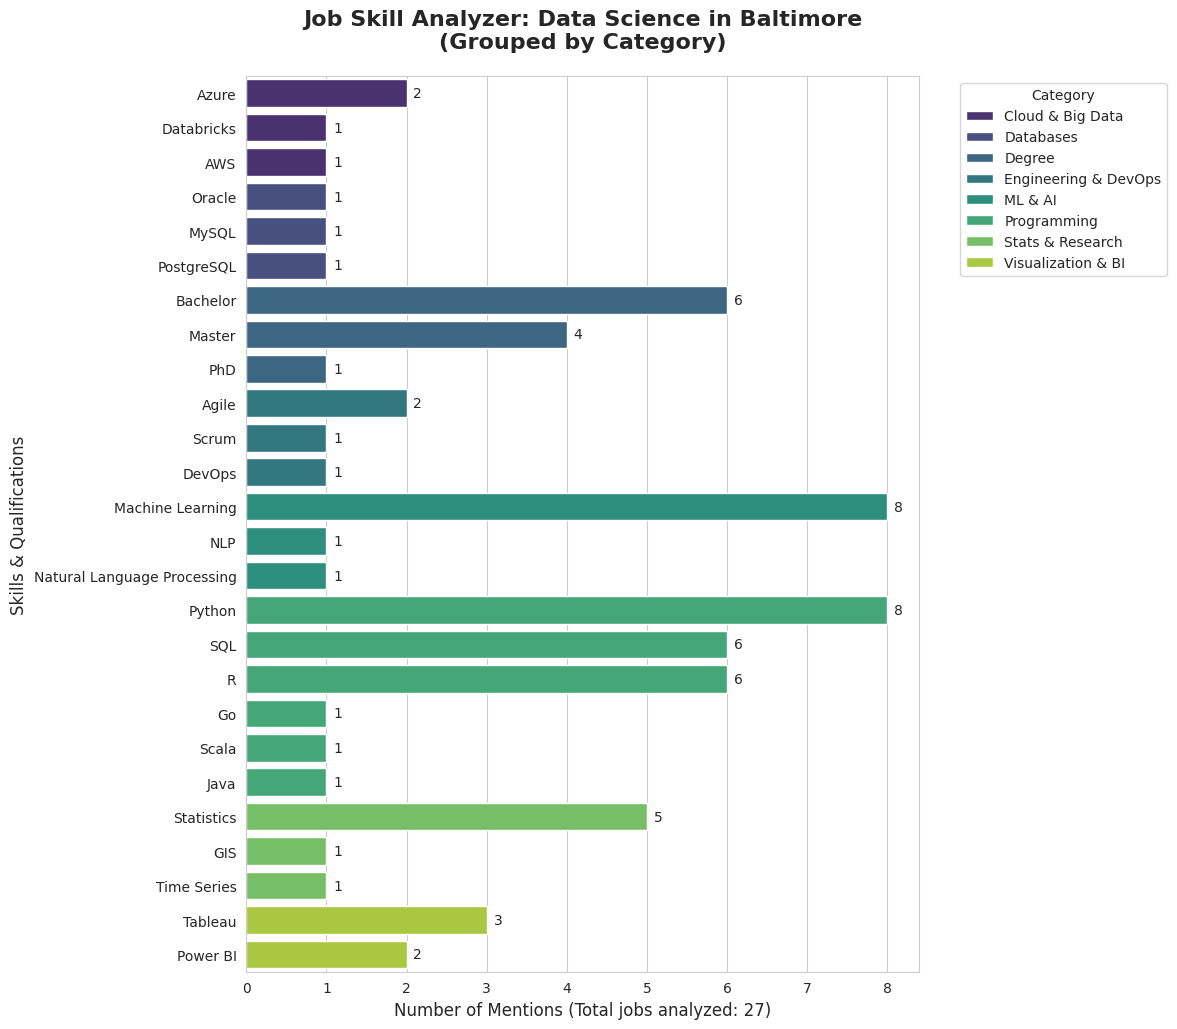

✅ 圖表已儲存為 skill_analysis_report.png
✅ 統計表已儲存為 skill_statistics.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path

# 1. 讀取結果
file_name = 'jobs_final_fixed_v2.csv' # 請確認檔名正確
if not Path(file_name).exists():
    print(f"❌ 找不到檔案 {file_name}，請先執行抓取腳本。")
else:
    df = pd.read_csv(file_name)
    # 過濾出有抓取到內容的職缺 (Success 代表完整內容, Snippet 代表 API 簡述)
    df_valid = df[df['description'].notna()].copy()

    # 2. 定義針對你背景的關鍵字清單 (已整合 GIS 與完整分類)
    skill_keywords = {
        'Programming': ['Python', 'SQL', ' R ', 'SAS', 'Stata', 'Julia', 'C++', 'Java', 'Scala', 'Go', 'Bash', 'Shell'],
        'Cloud & Big Data': ['AWS', 'Azure', 'GCP', 'Google Cloud', 'Snowflake', 'Databricks', 'Spark', 'Hadoop', 'Kafka', 'Redshift', 'BigQuery', 'Athena', 'Glue', 'Terraform', 'Airflow'],
        'Databases': ['PostgreSQL', 'MySQL', 'MongoDB', 'NoSQL', 'SQL Server', 'Oracle', 'Cassandra'],
        'ML & AI': ['Machine Learning', 'Deep Learning', 'Reinforcement Learning', 'NLP', 'Natural Language Processing', 'Computer Vision', 'Generative AI', 'GenAI', 'LLM', 'GPT', 'Scikit-learn', 'TensorFlow', 'PyTorch', 'Keras', 'XGBoost', 'LightGBM', 'CatBoost'],
        'Stats & Research': ['Statistics', 'Biostatistics', 'Causal Inference', 'Epidemiology', 'Econometrics', 'Bayesian', 'Survival Analysis', 'Longitudinal', 'Time Series', 'A/B Testing', 'Experimental Design', 'Propensity Score', 'Clinical Trials', 'Regression', 'Hypothesis Testing', 'RCT', 'GIS'],
        'Visualization & BI': ['Tableau', 'Power BI', 'Looker', 'Qlik', 'Matplotlib', 'Seaborn', 'Plotly', 'Shiny', 'D3.js'],
        'Engineering & DevOps': ['Git', 'GitHub', 'CI/CD', 'Docker', 'Kubernetes', 'MLOps', 'Agile', 'Scrum', 'DevOps'],
        'Degree': ['PhD', 'Ph.D.', 'Doctorate', 'Master', 'M.S.', 'MSc', 'MPH', 'MBA', 'Bachelor']
    }

    # 建立「正規化」後的類別查找表 (處理 Ph.D. -> PhD 的對應)
    norm_skill_to_cat = {}
    for cat, ks in skill_keywords.items():
        for k in ks:
            val = k.strip()
            if val == 'Ph.D.': val = 'PhD'
            if val == 'M.S.': val = 'Master'
            norm_skill_to_cat[val] = cat

    def find_skills_refined(text):
        if pd.isna(text): return []
        res = []
        for cat, kws in skill_keywords.items():
            for k in kws:
                # 使用 \b 確保單字邊界，避免 Python 抓到 "Pythons" 或 R 抓到 "Program"
                pattern = r'\b' + re.escape(k.strip()) + r'\b'
                if re.search(pattern, text, re.I):
                    val = k.strip()
                    # 歸一化處理
                    if val == 'Ph.D.': val = 'PhD'
                    if val == 'M.S.': val = 'Master'
                    res.append(val)
        return list(set(res))

    # 3. 數據分析與處理
    df_valid['found_skills'] = df_valid['description'].apply(find_skills_refined)
    all_found = [item for sublist in df_valid['found_skills'] for item in sublist]

    if not all_found:
        print("⚠️ 未在描述中偵測到任何技能關鍵字。")
    else:
        skill_counts = pd.Series(all_found).value_counts().reset_index()
        skill_counts.columns = ['Skill', 'Count']

        # 映射類別
        skill_counts['Category'] = skill_counts['Skill'].map(norm_skill_to_cat)

        # 按類別與次數排序
        skill_counts = skill_counts.sort_values(['Category', 'Count'], ascending=[True, False])

        # 4. 繪圖
        plt.figure(figsize=(12, max(8, len(skill_counts) * 0.4))) # 動態調整高度
        sns.set_style("whitegrid")

        ax = sns.barplot(
            data=skill_counts,
            y='Skill',
            x='Count',
            hue='Category',
            dodge=False,
            palette='viridis'
        )

        # 加上數據標籤
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                ax.annotate(f'{int(width)}',
                            (width, p.get_y() + p.get_height() / 2),
                            ha = 'left', va = 'center',
                            xytext = (5, 0),
                            textcoords = 'offset points',
                            fontsize=10)

        plt.title('Job Skill Analyzer: Data Science in Baltimore\n(Grouped by Category)', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(f'Number of Mentions (Total jobs analyzed: {len(df_valid)})', fontsize=12)
        plt.ylabel('Skills & Qualifications', fontsize=12)
        plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.savefig('skill_analysis_report.png', dpi=300)
        plt.show()

        # 額外儲存一份統計表
        skill_counts.to_csv('skill_statistics.csv', index=False, encoding='utf-8-sig')
        print(f"✅ 圖表已儲存為 skill_analysis_report.png")
        print(f"✅ 統計表已儲存為 skill_statistics.csv")

In [ ]:
# ==========================================
# Adzuna Job Fetcher + Cloudscraper (Anti-403)
# ==========================================

import os
import requests
import pandas as pd
import time
import trafilatura
import cloudscraper
import re
from datetime import datetime, timedelta
from pathlib import Path
from google.colab import userdata

# -------------------------
# Load environment variables
# -------------------------
try:
    APP_ID = userdata.get('ADZUNA_APP_ID')
    APP_KEY = userdata.get('ADZUNA_APP_KEY')
except:
    APP_ID = None
    APP_KEY = None

if not APP_ID or not APP_KEY:
    raise ValueError("❌ Missing Adzuna API credentials. 請檢查 Colab 左側『鑰匙』圖示內的名稱是否正確。")

# -------------------------
# Config
# -------------------------
COUNTRY = "us"
CITY = "Baltimore"
KEYWORDS = ["data scientist", "data analyst"]
RESULTS_PER_PAGE = 50
MAX_PAGES = 5
DAYS_BACK = 60
BASE_URL = f"https://api.adzuna.com/v1/api/jobs/{COUNTRY}/search"

# 🎯 Title Filtering Rules
TARGET_TITLE_KEYWORDS = ["data scientist", "senior data scientist", "sr. data scientist", "lead data scientist", "principal data scientist", "staff data scientist", "data analyst", "senior data analyst"]
EXCLUDED_TITLE_KEYWORDS = ["architect", "engineer", "manager", "consultant", "director", "vp", "vice president", "head of", "marketing", "sales", "product"]

# 初始化破解器
scraper = cloudscraper.create_scraper(browser={'browser': 'chrome', 'platform': 'windows', 'mobile': False})

def is_relevant_title(title: str) -> bool:
    if not title: return False
    title_lower = title.lower()
    has_target = any(k in title_lower for k in TARGET_TITLE_KEYWORDS)
    has_excluded = any(k in title_lower for k in EXCLUDED_TITLE_KEYWORDS)
    return has_target and not has_excluded

def quick_skill_scan(text):
    """簡單掃描文字中包含的技能關鍵字"""
    if not text: return ""
    skills = ['Python', 'SQL', ' R ', 'SAS', 'Stata', 'Machine Learning', 'Causal Inference', 'PhD', 'Epidemiology', 'Tableau', 'Power BI']
    found = [s.strip() for s in skills if re.search(r'\b' + re.escape(s.strip()) + r'\b', text, re.I)]
    return ", ".join(list(set(found)))

# -------------------------
# 🌐 強效版 Web Scraping Logic (對抗高級防護)
# -------------------------
def fetch_full_description(url):
    """
    使用進階 cloudscraper 設置繞過更嚴格的 403 封鎖
    """
    # 建立多種可能的 User-Agent 輪替
    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'desktop': True
        }
    )

    try:
        # 增加一次重試機會
        for _ in range(2):
            response = scraper.get(url, timeout=20)

            if response.status_code == 200:
                # 使用 trafilatura 提取，並加入過濾短內容的邏輯
                content = trafilatura.extract(response.text, include_tables=True)
                if content and len(content) > 300:
                    return content.strip()

            # 如果失敗，稍微停頓換個姿勢重試
            time.sleep(2)

    except Exception as e:
        pass
    return None

# -------------------------
# Fetch Jobs
# -------------------------
all_jobs = []
cutoff_date = datetime.now() - timedelta(days=DAYS_BACK)

for keyword in KEYWORDS:
    for page in range(1, MAX_PAGES + 1):
        params = {
            "app_id": APP_ID,
            "app_key": APP_KEY,
            "what": keyword,
            "where": CITY,
            "results_per_page": RESULTS_PER_PAGE,
            "sort_by": "date",
        }

        print(f"📥 Fetching '{keyword}' | page {page}")
        response = requests.get(f"{BASE_URL}/{page}", params=params)
        response.raise_for_status()

        data = response.json()
        results = data.get("results", [])
        if not results: break

        for job in results:
            created = job.get("created")
            created_dt = datetime.fromisoformat(created.replace("Z", ""))
            if created_dt < cutoff_date: continue

            title = job.get("title")
            if not is_relevant_title(title): continue

            # --- 開始抓取完整描述 ---
            redirect_url = job.get("redirect_url")
            print(f"   🔍 Anti-403 Scraping for: {title[:35]}...")

            full_desc = fetch_full_description(redirect_url)

            # 判斷狀態
            status = "Success" if full_desc else "Failed/Snippet"
            final_description = full_desc if full_desc else job.get("description")

            all_jobs.append({
                "title": title,
                "company": job.get("company", {}).get("display_name"),
                "location": job.get("location", {}).get("display_name"),
                "created": created,
                "description": final_description,
                "full_text_status": status,
                "detected_skills": quick_skill_scan(final_description),
                "redirect_url": redirect_url,
                "keyword": keyword,
            })

            # 💡 禮貌爬蟲：長網址處理需要時間，建議間隔 1.5 秒
            time.sleep(1.5)

print("\n✅ Fetch and Scraping completed")
print(f"🔢 Total jobs collected: {len(all_jobs)}")

# -------------------------
# Save to CSV
# -------------------------
output_path = Path("jobs_final_fixed_v2.csv")
df = pd.DataFrame(all_jobs)
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"💾 Saved to {output_path.resolve()}")
df[['title', 'full_text_status', 'detected_skills']].head()

✅ Collected 50 Data Scientist jobs


,title,company,location,description,via,posted_at,job_link,fetched_at
0,"Data Scientist-Remote, DMV Area",IIIIIIUS,"Silver Spring, MD",Description\n\nICF is seeking mid-to-senior le...,ICF Career,20 hours ago,None,2026-01-15T20:19:40.733735
1,Data Scientist,Defense Counterintelligence and Security Agency,"Quantico, VA (+5 others)",DCSA's PEO (National Background Investigation ...,USAJobs,11 days ago,None,2026-01-15T20:19:40.733803
2,Data Scientist SME,Leidos,"Alexandria, VA",Description\n\nLeidos National Security Sector...,Leidos Careers,2 days ago,None,2026-01-15T20:19:40.733823
3,DATA SCIENTIST,AF Force Renewal,"Washington, DC (+44 others)",The PALACE Acquire Program offers you a perman...,Federal Internship Portal - USAJobs,None,None,2026-01-15T20:19:40.733838
4,Data Scientist 4,RealmOne,Maryland,Are you VIGILANT about your career? RealmOne d...,Indeed,2 days ago,None,2026-01-15T20:19:40.733851
